# Contents
- [Create emissions data](#Create-emissions-data)
- [Import data](#Import-data)
- [Calculate forcing](#Calculate-radiative-forcing-and-cumulative-forcing)
- [Functions for SI figures](#Functions-for-SI-figures)
- 

## Figure guidelines
From [Nature Communications](https://www.nature.com/nature/for-authors/final-submission)

### Lettering
Lettering should be in a sans-serif typeface, preferably Helvetica or Arial, the same font throughout all figures in the paper. Units, capitalization, etc. should follow Nature style. Where practical, avoid placing lettering directly over images or shaded areas.

Separate panels in multi-part figures should each be labelled with 8 pt bold, upright (not italic) a, b, c. Maximum text size for all other text should be 7 pt; minimum text size should be 5 pt. Amino-acid sequences should be presented in one-letter code in Courier.

Do not rasterize or covert text to outlines.

### Sizing
Nature will often reduce figures to the smallest size possible for reasons of space. Authors are encouraged to indicate the smallest possible size they think appropriate for their figures, but Nature reserves the right to make the final decision.

For guidance, Nature's standard figure sizes are 89 mm  - 3.5 inches - wide (single column) and 183 mm - 7.2 inches -wide (double column). The full depth of a Nature page is 247 mm. Figures can also be a column-and-a-half where necessary (120–136 mm, 4.72-5.35).

Authors should check (using a reducing photocopier) that, at the smallest possible size, lettering remains readable and lines are sufficiently (but not too) heavy to print clearly. Line weights and strokes should be set between 0.25 and 1 pt at the final size (lines thinner than 0.25 pt may vanish in print). Do not rasterize or outline these lines if possible.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from ghgforcing import CO2, CH4
import sys
import os
from os.path import join
from pathlib import Path
idx = pd.IndexSlice
fig_path = join('..', 'Figures')

In [2]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [4]:
%aimport emissions
from emissions import emissions

%aimport heatmap
from heatmap import Main_figure

In [5]:
%load_ext watermark

In [6]:
%watermark -v -p ghgforcing,matplotlib

CPython 3.6.2
IPython 6.2.1

ghgforcing 0.1.7.1
matplotlib 2.1.2


## Create emissions data
Skip to `Import data` if you created emissions data in the Jupyter notebook.

In [7]:
start_years = [0, 10, 20]
emissions_df = pd.concat(emissions(CCS_start=year,
                                   leak_values=range(1, 11),
                                   year_to_90CCS=year)
                         for year in start_years)
emissions_df.reset_index(inplace=True, drop=True)
index_cols = ['Fuel', 'Leak', 'Methane', 'CCS', 'Start year']
emissions_df.set_index(index_cols, inplace=True)
emissions_df.sort_index(inplace=True)

In [8]:
emissions_df.head()

CO2       CH4  Time
Fuel Leak Methane CCS Start year                          
Coal SCPC -       0%  0           785.9175  2.489112  0.00
                      0           785.9175  2.489112  0.01
                      0           785.9175  2.489112  0.02
                      0           785.9175  2.489112  0.03
                      0           785.9175  2.489112  0.04

In [9]:
emissions_df.tail()

CO2  CH4    Time
Fuel Leak    Methane CCS Start year                  
NG   NGCC 9% Reduce  90% 20          0.0  0.0   99.96
                         20          0.0  0.0   99.97
                         20          0.0  0.0   99.98
                         20          0.0  0.0   99.99
                         20          0.0  0.0  100.00

In [10]:
emissions_df.dtypes

CO2     float64
CH4     float64
Time    float64
dtype: object

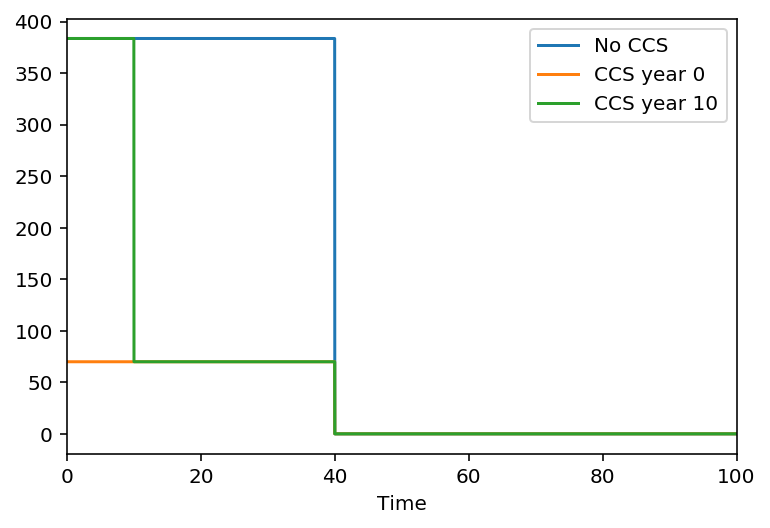

In [11]:
emissions_df.loc[idx['NG', 'NGCC 1%', 'Constant', '0%', 0]].plot('Time', 'CO2')
emissions_df.loc[idx['NG', 'NGCC 1%', 'Constant', '90%', 0]].plot('Time', 'CO2', ax=plt.gca())
emissions_df.loc[idx['NG', 'NGCC 1%', 'Constant', '90%', 10]].plot('Time', 'CO2', ax=plt.gca())

plt.legend(['No CCS', 'CCS year 0', 'CCS year 10'])

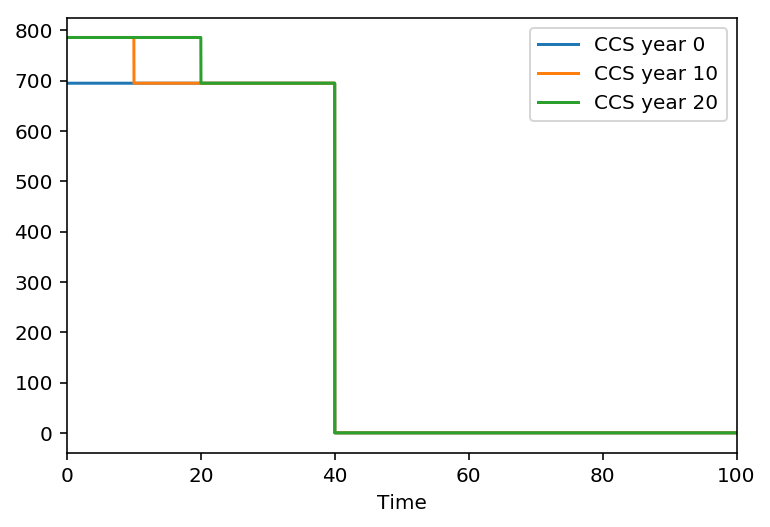

In [12]:
emissions_df.loc[idx['Coal', :, :, '16%', 0]].plot('Time', 'CO2')
emissions_df.loc[idx['Coal', :, :, '16%', 10]].plot('Time', 'CO2', ax=plt.gca())
emissions_df.loc[idx['Coal', :, :, '16%', 20]].plot('Time', 'CO2', ax=plt.gca())


plt.legend(['CCS year 0', 'CCS year 10', 'CCS year 20'])

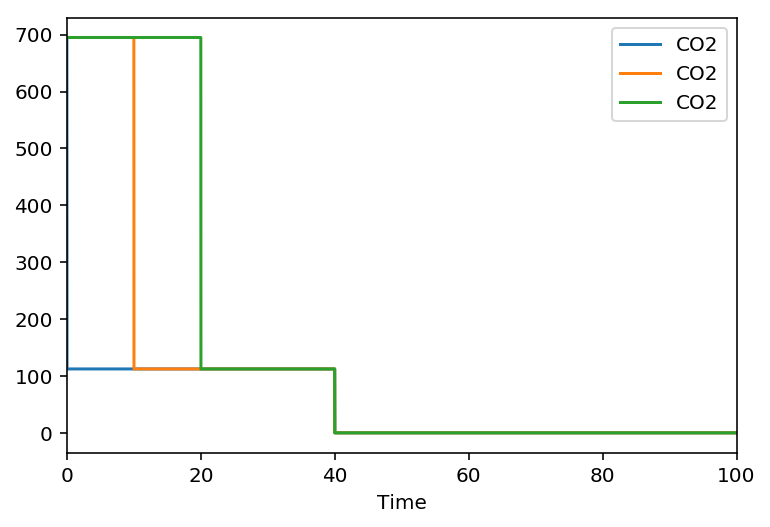

In [13]:
emissions_df.loc[idx['Coal', :, :, '16%-90%', 0]].plot('Time', 'CO2')
emissions_df.loc[idx['Coal', :, :, '16%-90%', 10]].plot('Time', 'CO2', ax=plt.gca())
emissions_df.loc[idx['Coal', :, :, '16%-90%', 20]].plot('Time', 'CO2', ax=plt.gca())
# plt.ylim(-10, 1000)

# plt.legend(['No CCS', 'CCS year 0', 'CCS year 10'])

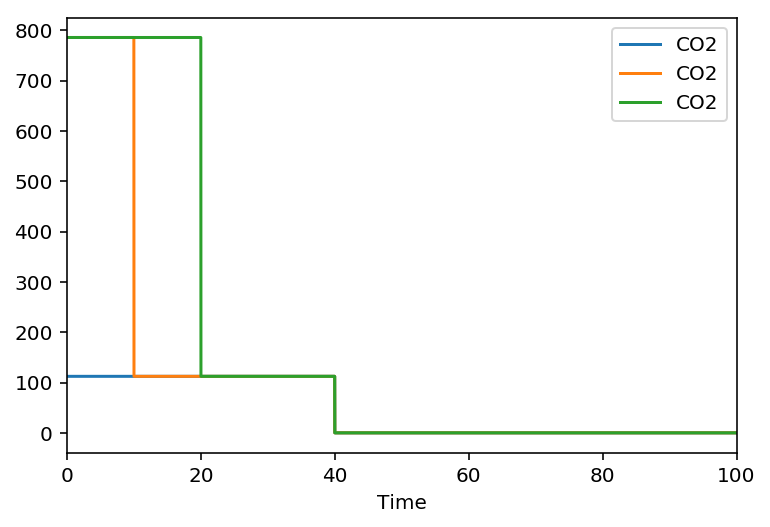

In [14]:
emissions_df.loc[idx['Coal', :, :, '90%', 0]].plot('Time', 'CO2')
emissions_df.loc[idx['Coal', :, :, '90%', 10]].plot('Time', 'CO2', ax=plt.gca())
emissions_df.loc[idx['Coal', :, :, '90%', 20]].plot('Time', 'CO2', ax=plt.gca())


# plt.legend(['No CCS', 'CCS year 0', 'CCS year 10'])

What are the methane emissions from NGCC at 1 and 3% emission rates?

In [15]:
(emissions_df.loc[idx[:, 'NGCC 1%'], 'CH4'].max(),
emissions_df.loc[idx[:, 'NGCC 3%'], 'CH4'].max())

# (emissions_df.loc[emissions_df['Leak'] == 'NGCC 1%', 'CH4'][:10000].max(),
# emissions_df.loc[emissions_df['Leak'] == 'NGCC 3%', 'CH4'].max())

(1.502, 4.5060000000000002)

## Import data
Skip this if you created data above

In [18]:
path = os.path.join('..', 'Data', 'all emissions.gz')
emissions_df_2 = pd.read_csv(path, dtype={'CO2': float,
                                        'CH4': float,
                                        'Start year': int})

In [11]:
emissions_df_2.dtypes

CO2           float64
CH4           float64
Leak           object
CCS            object
Fuel           object
Methane        object
Start year      int64
Time          float64
dtype: object

In [7]:
emissions_df['Start year'].unique()

array([ 0, 10, 20, 30])

## Calculate radiative forcing and cumulative forcing
The function below takes a list of dataframes, calculates the RF or CRF for each set of emissions, and converts them into a single dataframe. Each RF or CRF result is copied multiple times so that it can be used with a boolean filter when plotting comparisons. For example, the RF from an SCPC with 90% capture in year 0 is compared to the equivalent NGCC power plant, but it is also compared to an NGCC without CCS. Calculating the RF/CRF once and copying the results saves time.


We convert the RE of each species to a mass basis using the same methods as AR5: multiply by $(M_A/M_i)\cdot(10^9/T_M$), where $M_A$ is the average molecular weight of air (28.97 kg kmol$^{-1}$), $M_i$ is the molecular weight of the species in question, and $T_M$ is the total mass of the atmosphere ($5.1352 \times 10^{18}$kg)

In [16]:
ch4_re_ppb = 4.48E-4
M_A = 28.97
M_i = 16.04
T_M = 5.1352E18

ch4_re_mass = ch4_re_ppb * (M_A / M_i) * (1E9 / T_M)
ch4_re_mass

1.5756682448730954e-13

In [18]:
def emissions_to_forcing(df, delay_years=[0, 10, 20], kind='RF',
                         uncertainty=False, n_runs=250):
    """
    Convert a list of dataframes of emissions into forcing or cumulative forcing
    
    inputs:
        df: full dataframe of emissions
        delay_years: list of years that CCS is delayed by
        kind: RF or CRF
    output:
        complete_df: single dataframe with all results    
    """
    # Define some basic parameter values
    size = 1000 # MW
    hours = 365 * 24
    capacity_factor = 0.8

    generation = size * hours * capacity_factor #MWh/yr

    end = 100
    tstep = 0.01
    time = np.linspace(0, end, num=int(end/tstep+1)) #time array
    life = 60
    
    
    
    
    def calculations(df):
#         df.reset_index(inplace=True, drop=True)
        df.reset_index(inplace=True, drop=False)
        id_cols = ['Leak', 'CCS', 'Fuel', 'Methane', 'Start year']
        
        if uncertainty == True:
            # Define column names. Use 'kind' to add RF or CRF
            first_cols = [x + kind for x in ['CO2_', 'CH4_', '']]
            first_cols.extend(['CO2_' + kind + x for x in [' -sigma', ' +sigma']])
            first_cols.extend(['CH4_' + kind + x for x in [' -sigma', ' +sigma']])
            df_cols = first_cols + ['Leak', 'CCS', 'Fuel', 'Methane', 'Start year', 'Time']

            # Function to calculate RF or CRF for each df in the list
            out_df = pd.DataFrame(index=np.arange(0,101), columns=df_cols)
            co2 = CO2(df['CO2'], time, kind=kind, runs=n_runs) * generation 
            ch4 = CH4(df['CH4'], time, kind=kind, CH4_RE=ch4_re_mass * 1.65,
                      runs=n_runs) * generation 
            out_df.loc[:,'CO2_RF'] = co2.loc[:,'mean'].values
            out_df.loc[:,'CO2_RF -sigma'] = co2.loc[:,'-sigma'].values
            out_df.loc[:,'CO2_RF +sigma'] = co2.loc[:,'+sigma'].values
#             co2.loc[:,['mean', '-sigma', '+sigma']].values
            out_df.loc[:,'CH4_RF'] = ch4.loc[:,'mean'].values
            out_df.loc[:,'CH4_RF -sigma'] = ch4.loc[:,'-sigma'].values
            out_df.loc[:,'CH4_RF +sigma'] = ch4.loc[:,'+sigma'].values
#             out_df.loc[:,['CH4_RF', 'CH4_RF -sigma', 'CH4_RF +sigma']] = ch4.loc[:,['mean', '-sigma', '+sigma']].values
#             out_df.loc[:,'CH4_RF'] = CH4(df['CH4'], time, kind=kind) * generation #CH4
            out_df.loc[:,'RF'] = out_df.loc[:,'CO2_RF'] + out_df.loc[:,'CH4_RF'] #CO2 + CH4
            out_df[id_cols] = df.loc[0, id_cols].values
            out_df['Time'] = out_df.index
            
        if uncertainty == False:
            try:
                # Define column names. Use 'kind' to add RF or CRF
                first_cols = ['{}{}'.format(x, kind) for x in ['CO2_', 'CH4_', '']]
                df_cols = first_cols + ['Leak', 'CCS', 'Fuel', 'Methane', 'Start year', 'Time']

                # Function to calculate RF or CRF for each df in the list
                out_df = pd.DataFrame(index=np.arange(0,101), columns=df_cols)
                out_df.iloc[:,0] = CO2(df['CO2'], time, kind=kind) * generation #CO2
                out_df.iloc[:,1] = CH4(df['CH4'], time, CH4_RE=ch4_re_mass * 1.65,
                                       kind=kind) * generation #CH4
                out_df.iloc[:,2] = out_df.iloc[:,0] + out_df.iloc[:,1] #CO2 + CH4
                out_df[id_cols] = df.loc[0, id_cols].values
                out_df['Time'] = out_df.index
            except:
                print(df.head())
                print(out_df)
        
        return out_df
        
    # Create a list of dataframes that cover every scenario
    
    cols = ['Leak', 'CCS', 'Methane', 'Start year']
    grouped = list(df.groupby(cols))
#     print(grouped)
    
    complete_df = pd.concat(calculations(group) for _, group in grouped)
    
    complete_df.reset_index(drop=True, inplace=True)
    
    index_cols = ['Fuel', 'Leak', 'Methane', 'CCS', 'Start year', 'Time']
    complete_df.set_index(index_cols, inplace=True)
    complete_df.sort_index(inplace=True)
    
    return complete_df

In [19]:
RF = emissions_to_forcing(emissions_df)
CRF = emissions_to_forcing(emissions_df, kind='CRF')

In [20]:
RF.sort_index(inplace=True)
CRF.sort_index(inplace=True)

In [21]:
RF.head()

CO2_RF        CH4_RF  \
Fuel Leak Methane CCS Start year Time                               
Coal SCPC -       0%  0          0     9.671538e-08  4.535117e-08   
                                 1     9.437581e-06  4.401635e-06   
                                 2     1.820645e-05  8.423498e-06   
                                 3     2.650767e-05  1.213840e-05   
                                 4     3.442432e-05  1.557140e-05   

                                                 RF  
Fuel Leak Methane CCS Start year Time                
Coal SCPC -       0%  0          0     1.420666e-07  
                                 1     1.383922e-05  
                                 2     2.662995e-05  
                                 3     3.864607e-05  
                                 4     4.999573e-05

## Plot RF results

### Main figures with equal CCS deployment year

In [22]:
def replace_methane(df, original, new):
    _df = (df.reset_index()
             .replace({'Leak': original},
                      {'Leak': new}))
    
    return _df

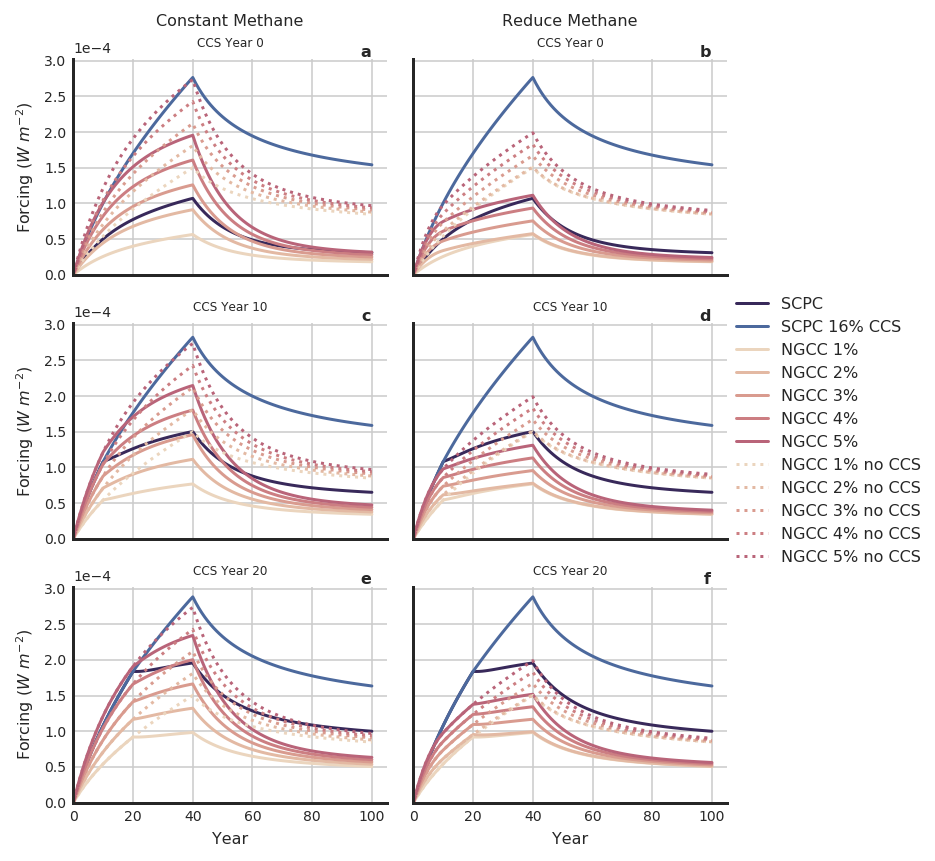

In [23]:
with sns.axes_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True}):
    coal_90 = idx['Coal', 'SCPC', '-', '90%', :, :]
    coal_16 = idx['Coal', 'SCPC', '-', '16%', :, :]
    coal_16_90 = idx['Coal', 'SCPC', '-', '16%-90%', :, :]
    coal_scenarios = ([RF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 90% CCS'})
                       ,
                       RF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 90% CCS'})
                       ,
                       RF.loc[coal_16, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'})
                      .replace({'Leak': 'SCPC'},
                               {'Leak': 'SCPC 16% CCS'}),
                       RF.loc[coal_16, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'})
                      .replace({'Leak': 'SCPC'},
                               {'Leak': 'SCPC 16% CCS'}),
#                        RF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'}),
#                        RF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'})
                      ])
    
    ng_90 = idx['NG', :, :, '90%', :, :]
    ng_0 = idx['NG', :, :, '0%', :, :]
    leaks = ['NGCC {}%'.format(x) for x in range(1, 6)]
    
    
    ng_scenarios = [replace_methane(RF.loc[idx['NG', x, :, '0%', :, :]], x, '{} no CCS'.format(x))
                    for x in leaks]
    ng_scenarios.append(RF.loc[ng_90].reset_index())

                     
    # Combine all scenarios into a single dataframe
    df = pd.concat(coal_scenarios + ng_scenarios)

    # Create a palette of colors for the scenarios
    colors = (sns.cubehelix_palette(2, start=0.4, rot=-.5, light=0.4, dark=0.2, hue=1, reverse=True)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.85, dark=0.5)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.85, dark=0.5))
    hue_order = (['SCPC', 'SCPC 16% CCS']
                 + leaks
                 + ['{} no CCS'.format(x) for x in leaks])
    markers = ['-'] * 7 + [':'] * 5
    col_order = ['Constant', 'Reduce']
    
    # Use FaceGrid to manage the figure layout
    g = sns.FacetGrid(df.loc[df['Leak'].isin(hue_order)], row='Start year',
                      col='Methane', col_order=col_order, hue='Leak',
                      hue_kws=dict(ls=markers),
                      hue_order=hue_order, palette=colors, size=2,
                      aspect=1.4)
    g.map(plt.plot, 'Time', 'RF').add_legend(title='', fontsize=8)
    
    label = 'Forcing ($W \ m^{-2}$)'
    g.set_ylabels(label, size=8)    
    g.set_xlabels('Year', size=8)
    g.set(ylim=(0,None), xlim=(0,None))

    # Clear previous title and set y-axis to scientific notation
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax.tick_params(axis='both', which='both',
                       labelsize=7)
        ax.yaxis.offsetText.set_fontsize(7)
#         ax.yaxis.set_major_formatter(mf)
    
    # Add figure labels separately so they don't get cleared
    for ax, label in zip(g.axes.flat, 'abcdef'):
#         plt.text(0.85, 0.79, label, fontsize=8, weight='bold',
#                  transform=ax.transAxes)
        ax.text(.95, 1.01, label, fontsize=8, weight='bold',
                 transform=ax.transAxes, ha='right')
        
        if label == 'a':
            ax.text(0.5, 1.15, 'Constant Methane', ha='center',
                    transform=ax.transAxes, size=8)
        if label == 'b':
            ax.text(0.5, 1.15, 'Reduce Methane', ha='center',
                    transform=ax.transAxes, size=8)
    
    # Custom title template
    g.set_titles(template="CCS Year {row_name}",# {col_name} Methane",
                 size=6)
    
    
    
    path = join(fig_path, 'RF test.pdf')
#     plt.savefig(path, bbox_inches='tight')

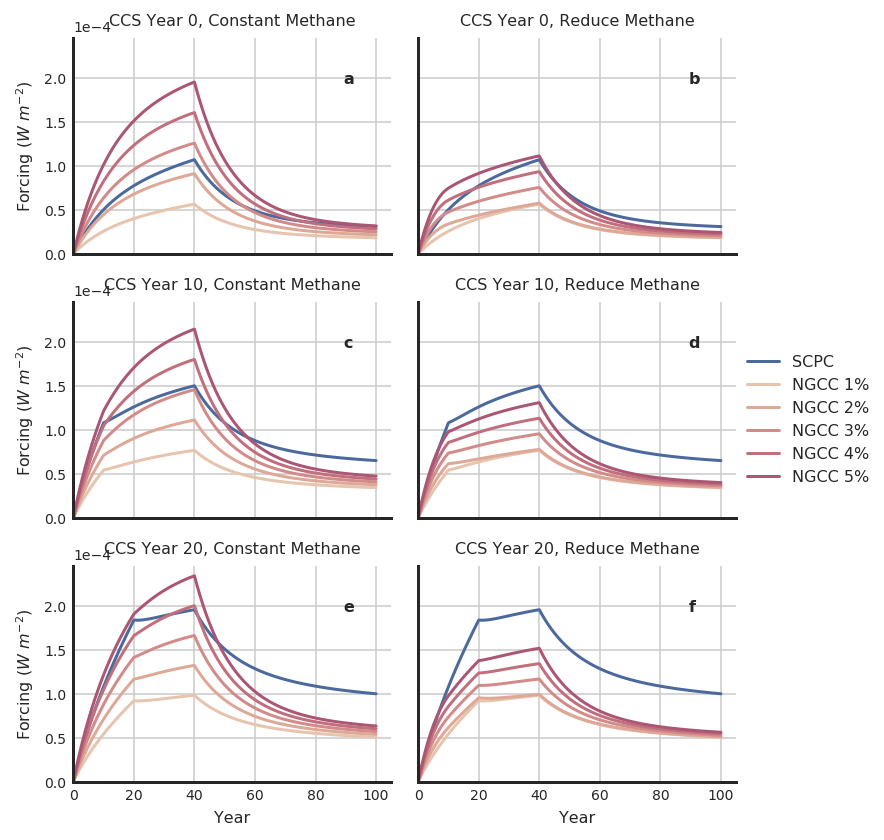

In [24]:
with sns.axes_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True}):
    coal_90 = idx['Coal', 'SCPC', '-', '90%', :, :]
    coal_16 = idx['Coal', 'SCPC', '-', '16%', :, :]
    coal_16_90 = idx['Coal', 'SCPC', '-', '16%-90%', :, :]
    coal_scenarios = ([RF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'}),
                       RF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'}),
#                        RF.loc[coal_16, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16% CCS'}),
#                        RF.loc[coal_16, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16% CCS'}),
#                        RF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'}),
#                        RF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'})
                      ])

    # Combine all scenarios into a single dataframe
    df = pd.concat(coal_scenarios + [RF.loc[idx['NG', :, :, '90%', :, :], :].reset_index()])

    # Create a palette of colors for the scenarios
    colors = (sns.cubehelix_palette(1, start=0.4, rot=-.5, light=0.4, dark=0.25, hue=1, reverse=True)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.8, dark=0.45))
    hue_order = ['SCPC'] + ['NGCC {}%'.format(x) for x in range(1, 6)]
    col_order = ['Constant', 'Reduce']
    
    # Use FaceGrid to manage the figure layout
    g = sns.FacetGrid(df.loc[df['Leak'].isin(hue_order)], row='Start year',
                      col='Methane', col_order=col_order, hue='Leak',
                      hue_order=hue_order, palette=colors, size=2,
                      aspect=1.4)
    g.map(plt.plot, 'Time', 'RF').add_legend(title='', fontsize=8)
    
    label = 'Forcing ($W \ m^{-2}$)'
    g.set_ylabels(label, size=8)    
    g.set_xlabels('Year', size=8)
    g.set(ylim=(0,None), xlim=(0,None))

    # Clear previous title and set y-axis to scientific notation
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax.tick_params(axis='both', which='both',
                       labelsize=7)
        ax.yaxis.offsetText.set_fontsize(7)
#         ax.yaxis.set_major_formatter(mf)
    
    # Add figure labels separately so they don't get cleared
    for ax, label in zip(g.axes.flat, 'abcdef'):
        plt.text(0.85, 0.79, label, fontsize=8, weight='bold',
                 transform=ax.transAxes)
    
    # Custom title template
    g.set_titles(template="CCS Year {row_name}, {col_name} Methane",
                 size=8)
    
    
    path = join(fig_path, 'RF test.pdf')
    plt.savefig(path, bbox_inches='tight')

### CRF results

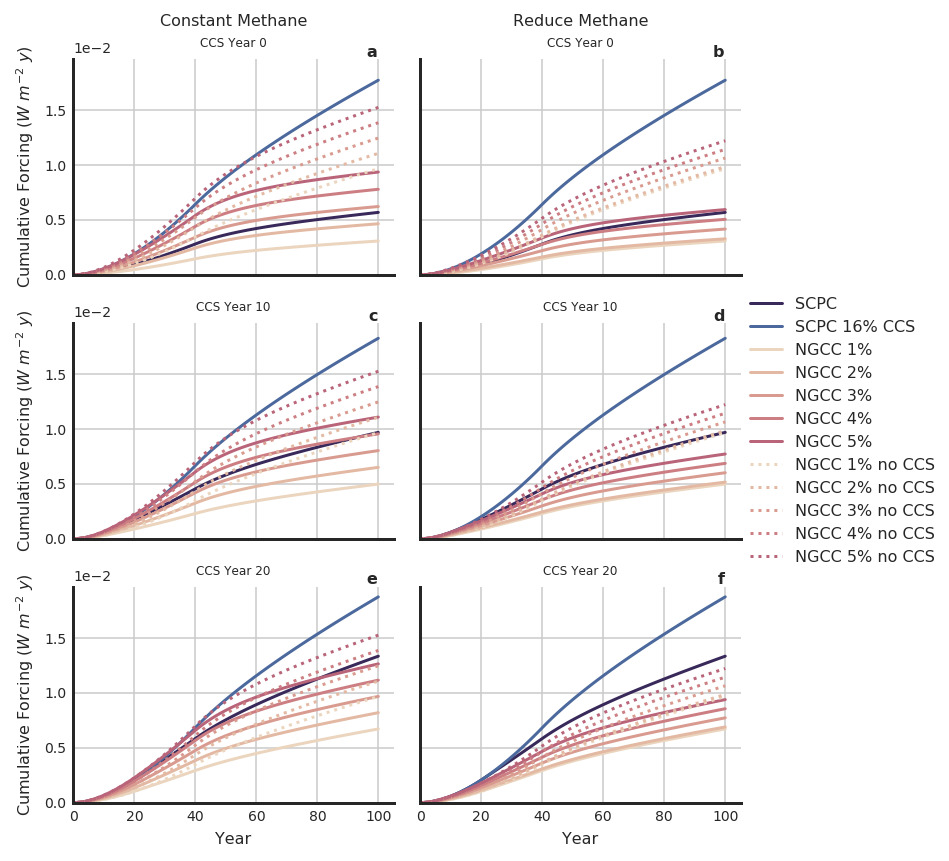

In [25]:
with sns.axes_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True}):
    coal_90 = idx['Coal', 'SCPC', '-', '90%', :, :]
    coal_16 = idx['Coal', 'SCPC', '-', '16%', :, :]
    coal_16_90 = idx['Coal', 'SCPC', '-', '16%-90%', :, :]
    coal_scenarios = ([CRF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 90% CCS'})
                       ,
                       CRF.loc[coal_90, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 90% CCS'})
                       ,
                       CRF.loc[coal_16, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'})
                      .replace({'Leak': 'SCPC'},
                               {'Leak': 'SCPC 16% CCS'}),
                       CRF.loc[coal_16, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'})
                      .replace({'Leak': 'SCPC'},
                               {'Leak': 'SCPC 16% CCS'}),
#                        CRF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Reduce'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'}),
#                        CRF.loc[coal_16_90, :]
#                       .reset_index()
#                       .replace({'Methane': '-'},
#                                {'Methane': 'Constant'})
#                       .replace({'Leak': 'SCPC'},
#                                {'Leak': 'SCPC 16%-90% CCS'})
                      ])
    
    ng_90 = idx['NG', :, :, '90%', :, :]
    ng_0 = idx['NG', :, :, '0%', :, :]
    leaks = ['NGCC {}%'.format(x) for x in range(1, 6)]
    
    
    ng_scenarios = [replace_methane(CRF.loc[idx['NG', x, :, '0%', :, :]], x, '{} no CCS'.format(x))
                    for x in leaks]
    ng_scenarios.append(CRF.loc[ng_90].reset_index())

                     
    # Combine all scenarios into a single dataframe
    df = pd.concat(coal_scenarios + ng_scenarios)

    # Create a palette of colors for the scenarios
    colors = (sns.cubehelix_palette(2, start=0.4, rot=-.5, light=0.4, dark=0.2, hue=1, reverse=True)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.85, dark=0.5)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.85, dark=0.5))
    hue_order = (['SCPC', 'SCPC 16% CCS']
                 + leaks
                 + ['{} no CCS'.format(x) for x in leaks])
    markers = ['-'] * 7 + [':'] * 5
    col_order = ['Constant', 'Reduce']
    
    # Use FaceGrid to manage the figure layout
    g = sns.FacetGrid(df.loc[df['Leak'].isin(hue_order)], row='Start year',
                      col='Methane', col_order=col_order, hue='Leak',
                      hue_kws=dict(ls=markers),
                      hue_order=hue_order, palette=colors, size=2,
                      aspect=1.4)
    g.map(plt.plot, 'Time', 'CRF').add_legend(title='', fontsize=8)
    
    label = 'Cumulative Forcing ($W \ m^{-2} \ y$)'
    g.set_ylabels(label, size=8)    
    g.set_xlabels('Year', size=8)
    g.set(ylim=(0,None), xlim=(0,None))

    # Clear previous title and set y-axis to scientific notation
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax.tick_params(axis='both', which='both',
                       labelsize=7)
        ax.yaxis.offsetText.set_fontsize(7)
#         ax.yaxis.set_major_formatter(mf)
    
    # Add figure labels separately so they don't get cleared
    for ax, label in zip(g.axes.flat, 'abcdef'):
#         plt.text(0.85, 0.79, label, fontsize=8, weight='bold',
#                  transform=ax.transAxes)
        ax.text(.95, 1.01, label, fontsize=8, weight='bold',
                 transform=ax.transAxes, ha='right')
        
        if label == 'a':
            ax.text(0.5, 1.15, 'Constant Methane', ha='center',
                    transform=ax.transAxes, size=8)
        if label == 'b':
            ax.text(0.5, 1.15, 'Reduce Methane', ha='center',
                    transform=ax.transAxes, size=8)
    
    # Custom title template
    g.set_titles(template="CCS Year {row_name}",# {col_name} Methane",
                 size=6)
    
    
    
    path = join(fig_path, 'CRF test.pdf')
#     plt.savefig(path, bbox_inches='tight')

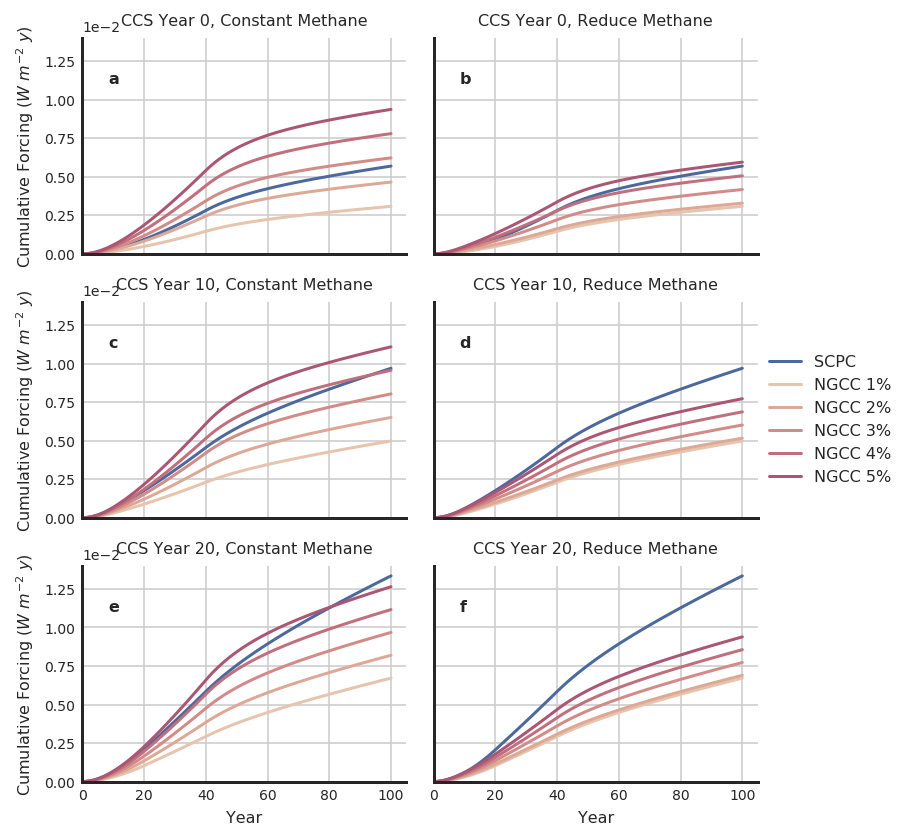

In [26]:
with sns.axes_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True}):

    # Years of CCS delay to include in the figure
    delays = [0, 10, 20]
    
    coal_now = idx['Coal', 'SCPC', '-', '90%', delays, :]
    coal_scenarios = ([CRF.loc[coal_now, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Reduce'}),
                       CRF.loc[coal_now, :]
                      .reset_index()
                      .replace({'Methane': '-'},
                               {'Methane': 'Constant'})])

    
    
    df = pd.concat(coal_scenarios + [CRF.loc[idx['NG', :, :, '90%', delays, :], :]
                                        .reset_index()])
    
    # Create a palette of colors for the scenarios
    colors = (sns.cubehelix_palette(1, start=0.4, rot=-.5, light=0.4, dark=0.25, hue=1, reverse=True)
              + sns.cubehelix_palette(5, start=0.2, hue=1, light=0.8, dark=0.45))
    hue_order = ['SCPC'] + ['NGCC {}%'.format(x) for x in range(1, 6)]
    col_order = ['Constant', 'Reduce']
    
    # Use FaceGrid to manage the figure layout
    g = sns.FacetGrid(df.loc[df['Leak'].isin(hue_order)], row='Start year',
                      col='Methane', col_order=col_order, hue='Leak',
                      hue_order=hue_order, palette=colors, size=2,
                      aspect=1.4)
    g.map(plt.plot, 'Time', 'CRF').add_legend(title='', fontsize=8)
    
    label = 'Cumulative Forcing ($W \ m^{-2} \ y$)'
    g.set_ylabels(label, size=8)    
    g.set_xlabels('Year', size=8)
    g.set(ylim=(0,None), xlim=(0,None))

    # Clear previous title and set y-axis to scientific notation
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax.tick_params(axis='both', which='both',
                       labelsize=7)
        ax.yaxis.offsetText.set_fontsize(7)
#         ax.yaxis.set_major_formatter(mf)
    
    # Add figure labels separately so they don't get cleared
    for ax, label in zip(g.axes.flat, 'abcdef'):
        plt.text(0.08, 0.79, label, fontsize=8, weight='bold',
                 transform=ax.transAxes)
    
    # Custom title template
    g.set_titles(template="CCS Year {row_name}, {col_name} Methane",
                 size=8)
    
    
    path = join(fig_path, 'CRF test.pdf')
    plt.savefig(path, bbox_inches='tight')

### Climate benefits of reducing methane and CCS

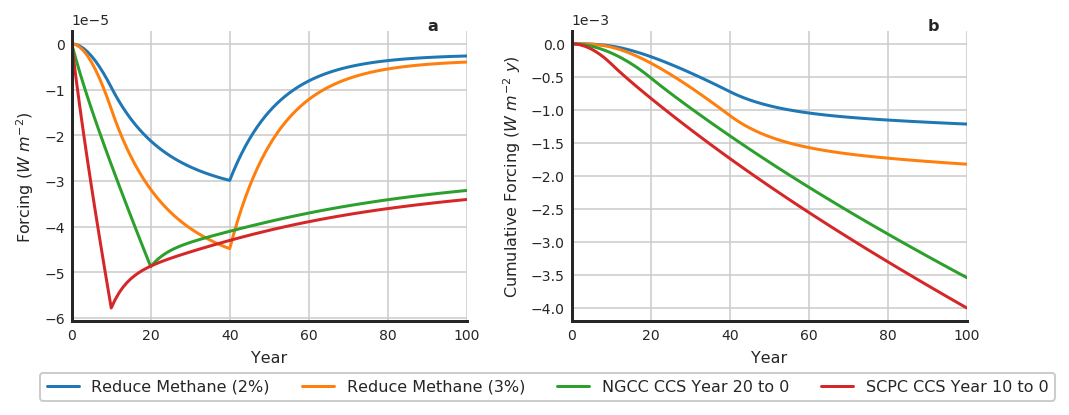

In [27]:
with sns.axes_style('white', {'axes.linewidth': 1.5,
                              'axes.grid': True}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.7))
    
    line1 = (RF.loc[idx['NG', 'NGCC 2%', 'Reduce', '0%', 20, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 2%', 'Constant', '0%', 20, :], 'RF'].values)
     .reset_index('Time').plot(x='Time', ax=ax1, legend=False))

    line2 = (RF.loc[idx['NG', 'NGCC 3%', 'Reduce', '0%', 20, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 3%', 'Constant', '0%', 20, :], 'RF'].values)
     .reset_index('Time').plot(x='Time', ax=ax1, legend=False))
    
    line3 = (RF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 0, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 20, :], 'RF'].values)
     .reset_index('Time').plot(x='Time', ax=ax1, legend=False))

    line4 = (RF.loc[idx['Coal', 'SCPC', '-', '90%', 0, :], 'RF']
     .sub(RF.loc[idx['Coal', 'SCPC', '-', '90%', 10, :], 'RF'].values)
     .reset_index('Time').plot(x='Time', ax=ax1, legend=False))
    
    (CRF.loc[idx['NG', 'NGCC 2%', 'Reduce', '0%', 20, :], 'CRF']
     .sub(CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '0%', 20, :], 'CRF'].values)
     .reset_index('Time').plot(x='Time', ax=ax2, legend=False))
    
    (CRF.loc[idx['NG', 'NGCC 3%', 'Reduce', '0%', 20, :], 'CRF']
     .sub(CRF.loc[idx['NG', 'NGCC 3%', 'Constant', '0%', 20, :], 'CRF'].values)
     .reset_index('Time').plot(x='Time', ax=ax2, legend=False))

    (CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 0, :], 'CRF']
     .sub(CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 20, :], 'CRF'].values)
     .reset_index('Time').plot(x='Time', ax=ax2, legend=False))
    
    (CRF.loc[idx['Coal', 'SCPC', '-', '90%', 0, :], 'CRF']
     .sub(CRF.loc[idx['Coal', 'SCPC', '-', '90%', 10, :], 'CRF'].values)
     .reset_index('Time').plot(x='Time', ax=ax2, legend=False))

    ax1.legend(['Reduce Methane (2%)',
                'Reduce Methane (3%)',
                'NGCC CCS Year 20 to 0',
                'SCPC CCS Year 10 to 0'], framealpha=1,
               frameon=True, fontsize=8, ncol=4, loc='upper left',
               bbox_to_anchor=(-0.1, -0.15))
    ax1.set_ylabel('Forcing ($W \ m^{-2}$)', size=8)
    ax2.set_ylabel('Cumulative Forcing ($W \ m^{-2} \ y$)', size=8)
    ax1.set_xlabel('Year', size=8)
    ax2.set_xlabel('Year', size=8)
    sns.despine()
    for ax, label in zip((ax1, ax2), 'ab'):
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
        ax.tick_params(axis='both', which='both', labelsize=7)
        ax.yaxis.offsetText.set_fontsize(7)
        plt.text(0.9, 1, label, fontsize=8, weight='bold',
                 transform=ax.transAxes)
    
    plt.tight_layout()
    path = join(fig_path, 'RF CRF savings.pdf')
    plt.savefig(path, bbox_inches='tight')

#### Quantified reduction in RF and CRF

Reduce methane from 3%

In [28]:
(RF.loc[idx['NG', 'NGCC 3%', 'Reduce', '0%', 20, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 3%', 'Constant', '0%', 20, :], 'RF'].values))[35:45]

Fuel  Leak     Methane  CCS  Start year  Time
NG    NGCC 3%  Reduce   0%   20          35     -0.000043
                                         36     -0.000043
                                         37     -0.000044
                                         38     -0.000044
                                         39     -0.000044
                                         40     -0.000045
                                         41     -0.000042
                                         42     -0.000039
                                         43     -0.000036
                                         44     -0.000034
dtype: float64

Percent reduction of reducing methane from 2% vs CCS

In [29]:
((RF.loc[idx['NG', 'NGCC 2%', 'Reduce', '0%', 20, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 2%', 'Constant', '0%', 20, :], 'RF'].values))[35:45]

/ 
(RF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 0, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 20, :], 'RF'].values))[35:45].values)

Fuel  Leak     Methane  CCS  Start year  Time
NG    NGCC 2%  Reduce   0%   20          35      0.678709
                                         36      0.689303
                                         37      0.699573
                                         38      0.709549
                                         39      0.719261
                                         40      0.728137
                                         41      0.680157
                                         42      0.635771
                                         43      0.594700
                                         44      0.556689
dtype: float64

Percent reduction of CRF in year 100 from reducing methane from 2% vs CCS

In [30]:
((CRF.loc[idx['NG', 'NGCC 2%', 'Reduce', '0%', 20, :], 'CRF']
     .sub(CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '0%', 20, :], 'CRF'].values))[90:]

/ 
(CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 0, :], 'CRF']
     .sub(CRF.loc[idx['NG', 'NGCC 2%', 'Constant', '90%', 20, :], 'CRF'].values))[90:].values)

Fuel  Leak     Methane  CCS  Start year  Time
NG    NGCC 2%  Reduce   0%   20          90      0.369175
                                         91      0.366347
                                         92      0.363573
                                         93      0.360853
                                         94      0.358184
                                         95      0.355567
                                         96      0.352999
                                         97      0.350480
                                         98      0.348009
                                         99      0.345584
                                         100     0.343205
dtype: float64

RF benefit of moving CCS from year 20 to 0 on an NGCC

In [31]:
(RF.loc[idx['NG', 'NGCC 3%', 'Constant', '90%', 0, :], 'RF']
     .sub(RF.loc[idx['NG', 'NGCC 3%', 'Constant', '90%', 20, :], 'RF'].values))[35:45]

Fuel  Leak     Methane   CCS  Start year  Time
NG    NGCC 3%  Constant  90%  0           35     -0.000041
                                          36     -0.000041
                                          37     -0.000041
                                          38     -0.000041
                                          39     -0.000040
                                          40     -0.000040
                                          41     -0.000040
                                          42     -0.000040
                                          43     -0.000040
                                          44     -0.000040
dtype: float64

RF benefit of moving CCS from year 10 to 0 on an SCPC

In [32]:
(RF.loc[idx['Coal', 'SCPC', '-', '90%', 0, :], 'RF']
     .sub(RF.loc[idx['Coal', 'SCPC', '-', '90%', 10, :], 'RF'].values))[35:45]

Fuel  Leak  Methane  CCS  Start year  Time
Coal  SCPC  -        90%  0           35     -0.000044
                                      36     -0.000044
                                      37     -0.000044
                                      38     -0.000043
                                      39     -0.000043
                                      40     -0.000043
                                      41     -0.000043
                                      42     -0.000043
                                      43     -0.000042
                                      44     -0.000042
dtype: float64

### Visualize relative uncertainty from methane in NGCC

In [73]:
def relative_uncertainty(df_list=start_list, leak_change='Constant', coal_ccs='16%', gas_ccs='0%', 
                         n_runs=1000, leak_values = ['NGCC 1%', 'NGCC 2%', 'NGCC 3%', 'NGCC 4%', 
                                                     'NGCC 5%', 'NGCC 7%', 'NGCC 9%']):
    """
    Plot uncertainty in the SCPC and NGGG radiative forcing difference.
    
    inputs:
        df: list of dataframes with difference in emissions between the scenarios
        leak_change: str, either 'Constant' or 'Reduce'
        coal_ccs: str, representing the coal CCS capture scenario
        gas_ccs: str, representing the gas CCS capture scenario
        n_runs: int, number of monte carlo runs
        leak_values: list of str, leakage rate scenarios to include in the figure
        
    outputs:
        plot of radiative forcing for the difference in emissions with +/- 1 sigma uncertainty shown
    """
    # Compile df index values from the list of dataframes that will be used in the comparison
    ng_idx = []
    for idx, df in enumerate(df_list):
        if (df['Fuel'][0]=='NG' and df['Methane'][0]=='Constant' and df['CCS'][0]=='0%'
            and df['Leak'][0] in leak_values):
            ng_idx.append(idx)
        if (df['Fuel'][0]=='Coal' and df['CCS'][0]=='16%'):
            coal_idx = idx
            
    #coal emissions minus ngcc emissions in a new list
    emiss_diff = []
    for x in ng_idx:
        # for each ngcc df, subtract the scpc CO2 and CH4 emissions
        temp_df = start_list[x].copy()
        temp_df.loc[:,['CO2', 'CH4']] -= start_list[coal_idx].loc[:,['CO2', 'CH4']]
        
        # append the difference in emissions to a new list
        emiss_diff.append(temp_df)
        
    # calculate the RF and uncertainty for each (difference in) emission function in each scenario
    # the output from this function is one large df
    print 'Calculating uncertainty...'
    emiss_diff_mc = emissions_to_forcing(emiss_diff, uncertainty=True, n_runs=1000)
    print 'Finished'
    
    # Combine the CO2 and CH4 uncertainty
    emiss_diff_mc.loc[:,'+sigma'] = emiss_diff_mc.loc[:, ['CO2_RF +sigma', 'CH4_RF +sigma']].sum(axis=1)
    emiss_diff_mc.loc[:,'-sigma'] = emiss_diff_mc.loc[:, ['CO2_RF -sigma', 'CH4_RF -sigma']].sum(axis=1)
    
    # create the plot with filled uncertainty
    # make a color palette to match the number of leak values
    colors = sns.color_palette('GnBu_d', len(leak_values))
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots()
        for idx, leak in enumerate(leak_values):
            RF = emiss_diff_mc.loc[emiss_diff_mc['Leak']==leak, 'RF']
            sigma_plus = emiss_diff_mc.loc[emiss_diff_mc['Leak']==leak, '+sigma']
            sigma_minus = emiss_diff_mc.loc[emiss_diff_mc['Leak']==leak, '-sigma']

            plt.plot(range(101), RF, label=leak, c=colors[idx])
            plt.fill_between(range(101), sigma_plus, sigma_minus, color=colors[idx], alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc=0)
        ax.ticklabel_format(style='sci', axis='y')
    #     plt.legend(loc=0)
        plt.ylabel('Forcing ($W \ m^{-2}$)')
        plt.xlabel('Year')
        plt.xlim(0,None)

#### 111b scenario

Calculating uncertainty...
Finished


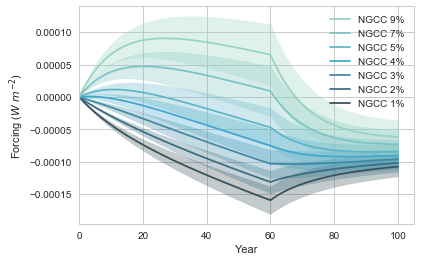

In [74]:
relative_uncertainty(leak_change='Constant',coal_ccs='16%', gas_ccs='0%')
plt.savefig('../Figures/Test uncertainty - 111b.pdf', bbox_inches='tight')

#### 90% CCS for both power plants

Calculating uncertainty...
Finished


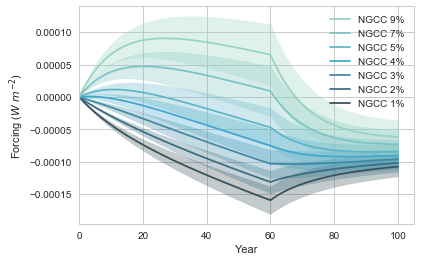

In [75]:
relative_uncertainty(leak_change='Constant', coal_ccs='90%', gas_ccs='90%')
plt.savefig('../Figures/Test uncertainty - both CCS.pdf', bbox_inches='tight')

## Main paper figures: difference in RF and CRF

Define scenarios for the main RF/CRF figures in a dictionary. Additional scenarios for CCS start year of 0 and 20 are not included here - they will be used in the figure generation function.

In [34]:
RF.tail()

CO2_RF    CH4_RF        RF
Fuel Leak    Methane CCS Start year Time                              
NG   NGCC 9% Reduce  90% 20         96    0.000048  0.000017  0.000064
                                    97    0.000048  0.000016  0.000064
                                    98    0.000048  0.000016  0.000064
                                    99    0.000047  0.000016  0.000064
                                    100   0.000047  0.000016  0.000063

In [35]:
_RF = RF.loc[idx['Coal', :, :, '90%', :, :], :].copy()
_CRF = CRF.loc[idx['Coal', :, :, '90%', :, :], :].copy()

In [36]:
idx_0 = idx['Coal', :, :, '90%', 0, :]
idx_10 = idx['Coal', :, :, '90%', 10, :]
idx_20 = idx['Coal', :, :, '90%', 20, :]

_RF.loc[idx_10, :] = _RF.loc[idx_0].values
_RF.loc[idx_20, :] = _RF.loc[idx_0].values

_CRF.loc[idx_10, :] = _CRF.loc[idx_0].values
_CRF.loc[idx_20, :] = _CRF.loc[idx_0].values

_RF.index = _RF.index.set_levels('_'+_RF.index.get_level_values(3), level=3)
_CRF.index = _CRF.index.set_levels('_'+_CRF.index.get_level_values(3), level=3)

In [37]:
_RF.head()

CO2_RF        CH4_RF  \
Fuel Leak Methane CCS  Start year Time                               
Coal SCPC -       _90% 0          0     1.382246e-08  5.687688e-08   
                                  1     1.348809e-06  5.520282e-06   
                                  2     2.602046e-06  1.056428e-05   
                                  3     3.788448e-06  1.522330e-05   
                                  4     4.919888e-06  1.952878e-05   

                                                  RF  
Fuel Leak Methane CCS  Start year Time                
Coal SCPC -       _90% 0          0     7.069934e-08  
                                  1     6.869091e-06  
                                  2     1.316632e-05  
                                  3     1.901174e-05  
                                  4     2.444867e-05

In [38]:
fig_scenarios = {'a' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
                 'b' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Constant'},
                 'c' : {'Coal CCS' : '16%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
                 'd' : {'Coal CCS' : '16%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Constant'},
                 'e' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
                 'f' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Reduce'},
                 'g' : {'Coal CCS' : '16%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
                 'h' : {'Coal CCS' : '16%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Reduce'}}

In [33]:
fig_scenarios = {'a' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
                 'b' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Constant'},
                 'c' : {'Coal CCS' : '_90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
#                  'd' : {'Coal CCS' : '16%',
#                         'Gas CCS' : '0%',
#                         'Methane' : 'Constant'},
                 'd' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
                 'e' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Reduce'},
                 'f' : {'Coal CCS' : '_90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
#                  'h' : {'Coal CCS' : '16%',
#                         'Gas CCS' : '0%',
#                         'Methane' : 'Reduce'}
                }

### RF plot

In [38]:
RF2 = pd.concat([RF, _RF])
RF2.sort_index(inplace=True)

In [39]:
RF.head()

CO2_RF        CH4_RF  \
Fuel Leak Methane CCS Start year Time                               
Coal SCPC -       0%  0          0     9.671538e-08  4.535117e-08   
                                 1     9.437581e-06  4.401635e-06   
                                 2     1.820645e-05  8.423498e-06   
                                 3     2.650767e-05  1.213840e-05   
                                 4     3.442432e-05  1.557140e-05   

                                                 RF  
Fuel Leak Methane CCS Start year Time                
Coal SCPC -       0%  0          0     1.420666e-07  
                                 1     1.383922e-05  
                                 2     2.662995e-05  
                                 3     3.864607e-05  
                                 4     4.999573e-05

In [26]:
RF_short = RF2.loc[idx[:, :, :, :, :, :10], :]

In [27]:
RF_short.tail()

CO2_RF    CH4_RF        RF
Fuel Leak    Methane CCS Start year Time                              
NG   NGCC 9% Reduce  90% 20         6     0.000024  0.000071  0.000095
                                    7     0.000028  0.000077  0.000105
                                    8     0.000031  0.000082  0.000113
                                    9     0.000034  0.000086  0.000120
                                    10    0.000037  0.000088  0.000126

In [40]:
RF_fig = Main_figure()

In [41]:
RF_fig.figure_data(RF2.reset_index(), fig_scenarios, delay_years=[0, 10, 20])
RF_fig.set_cbar_scale()

In [42]:
RF_fig.set_color_values()

/Users/Home/anaconda/envs/ccs-timing/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


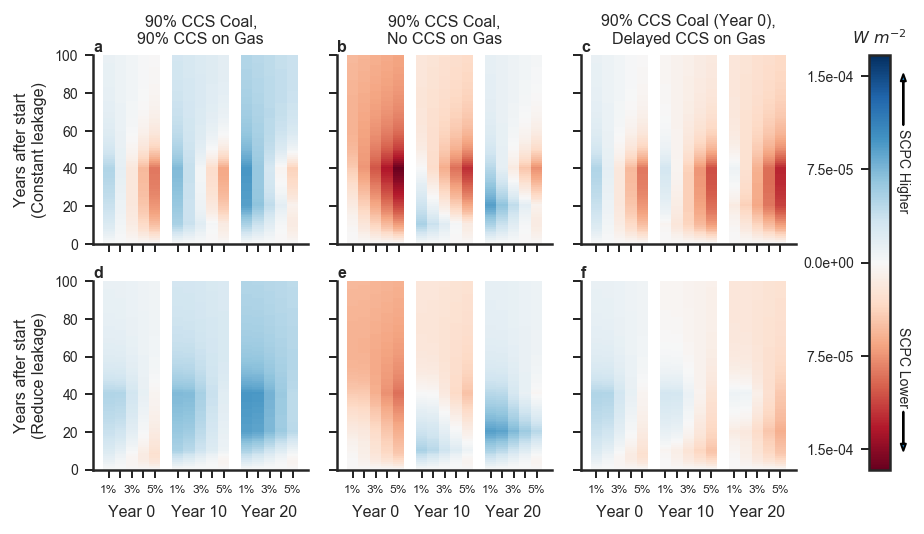

In [43]:
kwargs = dict(
        label_dict = dict(
            x=0.0,
            y=1.02,
            ha='left',
            size=8,
            weight='bold'
        ),
        year_label_dict = dict(
            size=8,
            y=-0.25,
            horizontalalignment='center'
        ),
        xtick_label_dict = dict(
            labelsize=6,
            length=4,
            width=1
         ),
        alt_titles = dict(
            a='90% CCS Coal,\n90% CCS on Gas',
            b='90% CCS Coal,\nNo CCS on Gas',
            c='90% CCS Coal (Year 0),\nDelayed CCS on Gas'
        ),
        year_label_loc = [0.18, 0.49, 0.82],
        arrowprops = dict(
            headwidth=2.5,
            headlength=3.5,
#             arrowstyle='simple',
            width = 0.001,
        ),
        cbar_arrow_x = 1.5,
)

RF_fig.plot_heatmap(font_scale=1, group_spacing=0.15, delay_years=[0, 10, 20], cols=3, figsize=[7.2, 3.6],
                    scenario_keys=fig_scenarios, cbar_pad=0.08, cbar=True, **kwargs)
path = join('..', 'Figures', 'Main paper RF fig 020818 alt_re.pdf')
plt.savefig(path, bbox_inches='tight')


### CRF plot

In [44]:
CRF2 = pd.concat([CRF, _CRF])
CRF2.sort_index(inplace=True)

In [45]:
CRF_fig = Main_figure()

In [46]:
CRF_fig.figure_data(CRF2.reset_index(), fig_scenarios, delay_years=[0, 10, 20], kind='CRF')
CRF_fig.set_cbar_scale()

In [47]:
CRF_fig.set_color_values()

/Users/Home/anaconda/envs/ccs-timing/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


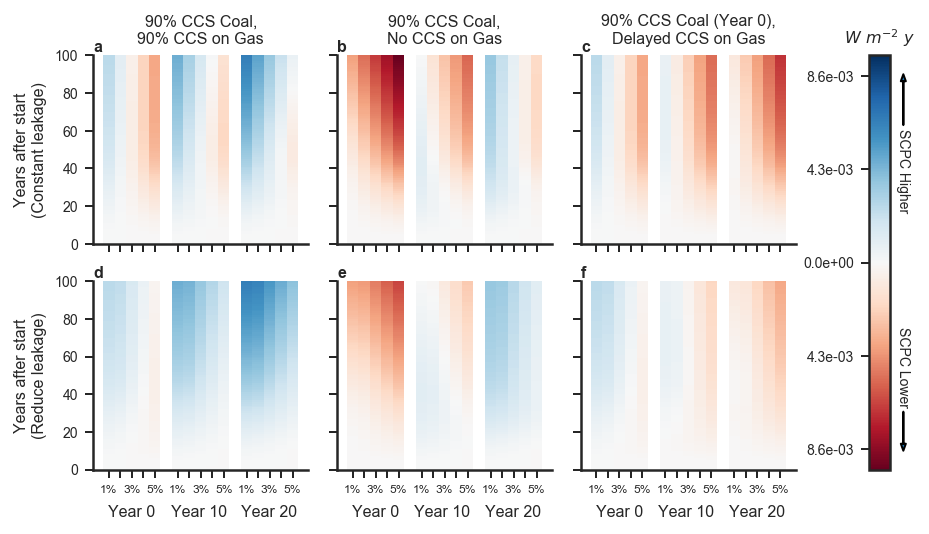

In [48]:
kwargs = dict(
        label_dict = dict(
            x=0.0,
            y=1.02,
            ha='left',
            size=8,
            weight='bold'
        ),
        year_label_dict = dict(
            size=8,
            y=-0.25,
            horizontalalignment='center'
        ),
        xtick_label_dict = dict(
            labelsize=6,
            length=4,
            width=1
         ),
        alt_titles = dict(
            a='90% CCS Coal,\n90% CCS on Gas',
            b='90% CCS Coal,\nNo CCS on Gas',
            c='90% CCS Coal (Year 0),\nDelayed CCS on Gas'
        ),
        year_label_loc = [0.18, 0.49, 0.82],
        arrowprops = dict(
            headwidth=2.5,
            headlength=3.5,
#             arrowstyle='simple',
            width = 0.001,
        ),
        cbar_arrow_x = 1.5,
)

CRF_fig.plot_heatmap(font_scale=1, group_spacing=0.15, delay_years=[0, 10, 20], cols=3, figsize=[7.2, 3.6],
                    scenario_keys=fig_scenarios, cbar_pad=0.08, cbar=True, **kwargs)
path = join('..', 'Figures', 'Main paper CRF fig 020818 alt_re.pdf')
plt.savefig(path, bbox_inches='tight')
